# English Premier League -  Top 4 Prediction for 2017/18

## Import Dependencies

In [192]:
from time import time
from sklearn.feature_selection import SelectKBest, chi2, RFE
from sklearn.preprocessing import scale
from sklearn.metrics import accuracy_score
from sklearn.model_selection import cross_val_score, train_test_split, GridSearchCV
from sklearn.multiclass import OneVsRestClassifier
from sklearn.linear_model import LogisticRegression
from sklearn.neighbors import KNeighborsClassifier
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import make_scorer
from sklearn.utils import shuffle
from sklearn import svm
from sklearn import tree, neighbors
from sklearn import preprocessing
from xgboost import XGBClassifier
from matplotlib.colors import ListedColormap
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
import random
import warnings

%matplotlib inline
warnings.filterwarnings("ignore")

## 1. Getting data from the official EPL website

## a. Web scraping

#### Using Scrapy attribution 'startproject' to organize scrapying codes in the other folders. You can check the codes in crawler files.  
>#### The code below are the example of web scrapying of the standing tables from 2010 to 2018. I wrote codes in the py files and executed in the prompt command.

In [ ]:
import scrapy
import time
from selenium import webdriver
from selenium.webdriver.support.select import Select
from scrapy.selector import Selector
from test_crawler.items import TestItem

class TestItem(scrapy.Item):
    club_name = scrapy.Field()
    position = scrapy.Field()
    won = scrapy.Field()
    drawn = scrapy.Field()
    lost = scrapy.Field()
    goal = scrapy.Field()
    goal_against = scrapy.Field()
    points = scrapy.Field()

class TESTSpider(scrapy.Spider):
    name = "Test"
    allowed_domains = ["premierleague.com"]
    start_urls = ["https://www.premierleague.com/tables"]
    
    def __init__(self):
        scrapy.Spider.__init__(self)
        self.browser = webdriver.Chrome("C:\sta\chromedriver.exe")
    
    def parse(self, response):
        self.browser.get(response.url)
        time.sleep(5)
#2017/18
        html = self.browser.find_element_by_xpath('//*').get_attribute('outerHTML')
        selector = Selector(text=html)
        rows = selector.xpath('//*[@id="mainContent"]/div[2]/div[1]/div[3]/div/div/div/table/tbody/tr[not(@class="expandable")]')
        for row in rows:
            item = TestItem()
            item["club_name"] = row.xpath('./td[3]/a/span[2]/text()')[0].extract()
            item["position"] = row.xpath('./td[2]/span[1]/text()')[0].extract()
            item["won"] = row.xpath('./td[5]/text()')[0].extract()
            item["lost"] = row.xpath('./td[7]/text()')[0].extract()
            item["drawn"] = row.xpath('./td[6]/text()')[0].extract()
            item["goal"] = row.xpath('./td[8]/text()')[0].extract()
            item["goal_against"] = row.xpath('./td[9]/text()')[0].extract()
            item["points"] = row.xpath('./td[11]/text()')[0].extract()
            yield item
#2016/17
        self.browser.find_element_by_xpath('//*[@id="mainContent"]/div[2]/div[1]/section/div[2]/div[2]').click()
        self.browser.find_element_by_xpath('//*[@id="mainContent"]/div[2]/div[1]/section/div[2]/ul/li[2]').click()
        time.sleep(8)
        html = self.browser.find_element_by_xpath('//*').get_attribute('outerHTML')
        selector = Selector(text=html)
        
        rows = selector.xpath('//*[@id="mainContent"]/div[2]/div[1]/div[3]/div/div/div/table/tbody/tr[not(@class="expandable")]')
        for row in rows:
            item = TestItem()
            item["club_name"] = row.xpath('./td[3]/a/span[2]/text()')[0].extract()
            item["position"] = row.xpath('./td[2]/span[1]/text()')[0].extract()
            item["won"] = row.xpath('./td[5]/text()')[0].extract()
            item["lost"] = row.xpath('./td[7]/text()')[0].extract()
            item["drawn"] = row.xpath('./td[6]/text()')[0].extract()
            item["goal"] = row.xpath('./td[8]/text()')[0].extract()
            item["goal_against"] = row.xpath('./td[9]/text()')[0].extract()
            item["points"] = row.xpath('./td[11]/text()')[0].extract()
            yield item
#2015/16
        self.browser.find_element_by_xpath('//*[@id="mainContent"]/div[2]/div[1]/section/div[2]/div[2]').click()
        self.browser.find_element_by_xpath('//*[@id="mainContent"]/div[2]/div[1]/section/div[2]/ul/li[3]').click()
        time.sleep(8)
        html = self.browser.find_element_by_xpath('//*').get_attribute('outerHTML')
        selector = Selector(text=html)
        
        rows = selector.xpath('//*[@id="mainContent"]/div[2]/div[1]/div[3]/div/div/div/table/tbody/tr[not(@class="expandable")]')
        for row in rows:
            item = TestItem()
            item["club_name"] = row.xpath('./td[3]/a/span[2]/text()')[0].extract()
            item["position"] = row.xpath('./td[2]/span[1]/text()')[0].extract()
            item["won"] = row.xpath('./td[5]/text()')[0].extract()
            item["lost"] = row.xpath('./td[7]/text()')[0].extract()
            item["drawn"] = row.xpath('./td[6]/text()')[0].extract()
            item["goal"] = row.xpath('./td[8]/text()')[0].extract()
            item["goal_against"] = row.xpath('./td[9]/text()')[0].extract()
            item["points"] = row.xpath('./td[11]/text()')[0].extract()
            yield item
#2014/15
        self.browser.find_element_by_xpath('//*[@id="mainContent"]/div[2]/div[1]/section/div[2]/div[2]').click()
        self.browser.find_element_by_xpath('//*[@id="mainContent"]/div[2]/div[1]/section/div[2]/ul/li[4]').click()
        time.sleep(8)
        html = self.browser.find_element_by_xpath('//*').get_attribute('outerHTML')
        selector = Selector(text=html)
        
        rows = selector.xpath('//*[@id="mainContent"]/div[2]/div[1]/div[3]/div/div/div/table/tbody/tr[not(@class="expandable")]')
        for row in rows:
            item = TestItem()
            item["club_name"] = row.xpath('./td[3]/a/span[2]/text()')[0].extract()
            item["position"] = row.xpath('./td[2]/span[1]/text()')[0].extract()
            item["won"] = row.xpath('./td[5]/text()')[0].extract()
            item["lost"] = row.xpath('./td[7]/text()')[0].extract()
            item["drawn"] = row.xpath('./td[6]/text()')[0].extract()
            item["goal"] = row.xpath('./td[8]/text()')[0].extract()
            item["goal_against"] = row.xpath('./td[9]/text()')[0].extract()
            item["points"] = row.xpath('./td[11]/text()')[0].extract()
            yield item
#2013/14
        self.browser.find_element_by_xpath('//*[@id="mainContent"]/div[2]/div[1]/section/div[2]/div[2]').click()
        self.browser.find_element_by_xpath('//*[@id="mainContent"]/div[2]/div[1]/section/div[2]/ul/li[5]').click()
        time.sleep(8)
        html = self.browser.find_element_by_xpath('//*').get_attribute('outerHTML')
        selector = Selector(text=html)
        
        rows = selector.xpath('//*[@id="mainContent"]/div[2]/div[1]/div[3]/div/div/div/table/tbody/tr[not(@class="expandable")]')
        for row in rows:
            item = TestItem()
            item["club_name"] = row.xpath('./td[3]/a/span[2]/text()')[0].extract()
            item["position"] = row.xpath('./td[2]/span[1]/text()')[0].extract()
            item["won"] = row.xpath('./td[5]/text()')[0].extract()
            item["lost"] = row.xpath('./td[7]/text()')[0].extract()
            item["drawn"] = row.xpath('./td[6]/text()')[0].extract()
            item["goal"] = row.xpath('./td[8]/text()')[0].extract()
            item["goal_against"] = row.xpath('./td[9]/text()')[0].extract()
            item["points"] = row.xpath('./td[11]/text()')[0].extract()
            yield item
#2012/13
        self.browser.find_element_by_xpath('//*[@id="mainContent"]/div[2]/div[1]/section/div[2]/div[2]').click()
        self.browser.find_element_by_xpath('//*[@id="mainContent"]/div[2]/div[1]/section/div[2]/ul/li[6]').click()
        time.sleep(8)
        html = self.browser.find_element_by_xpath('//*').get_attribute('outerHTML')
        selector = Selector(text=html)
        
        rows = selector.xpath('//*[@id="mainContent"]/div[2]/div[1]/div[3]/div/div/div/table/tbody/tr[not(@class="expandable")]')
        for row in rows:
            item = TestItem()
            item["club_name"] = row.xpath('./td[3]/a/span[2]/text()')[0].extract()
            item["position"] = row.xpath('./td[2]/span[1]/text()')[0].extract()
            item["won"] = row.xpath('./td[5]/text()')[0].extract()
            item["lost"] = row.xpath('./td[7]/text()')[0].extract()
            item["drawn"] = row.xpath('./td[6]/text()')[0].extract()
            item["goal"] = row.xpath('./td[8]/text()')[0].extract()
            item["goal_against"] = row.xpath('./td[9]/text()')[0].extract()
            item["points"] = row.xpath('./td[11]/text()')[0].extract()
            yield item
#2011/12
        self.browser.find_element_by_xpath('//*[@id="mainContent"]/div[2]/div[1]/section/div[2]/div[2]').click()
        self.browser.find_element_by_xpath('//*[@id="mainContent"]/div[2]/div[1]/section/div[2]/ul/li[7]').click()
        time.sleep(8)
        html = self.browser.find_element_by_xpath('//*').get_attribute('outerHTML')
        selector = Selector(text=html)
        
        rows = selector.xpath('//*[@id="mainContent"]/div[2]/div[1]/div[3]/div/div/div/table/tbody/tr[not(@class="expandable")]')
        for row in rows:
            item = TestItem()
            item["club_name"] = row.xpath('./td[3]/a/span[2]/text()')[0].extract()
            item["position"] = row.xpath('./td[2]/span[1]/text()')[0].extract()
            item["won"] = row.xpath('./td[5]/text()')[0].extract()
            item["lost"] = row.xpath('./td[7]/text()')[0].extract()
            item["drawn"] = row.xpath('./td[6]/text()')[0].extract()
            item["goal"] = row.xpath('./td[8]/text()')[0].extract()
            item["goal_against"] = row.xpath('./td[9]/text()')[0].extract()
            item["points"] = row.xpath('./td[11]/text()')[0].extract()
            yield item
#2010/11
        self.browser.find_element_by_xpath('//*[@id="mainContent"]/div[2]/div[1]/section/div[2]/div[2]').click()
        self.browser.find_element_by_xpath('//*[@id="mainContent"]/div[2]/div[1]/section/div[2]/ul/li[8]').click()
        time.sleep(8)
        html = self.browser.find_element_by_xpath('//*').get_attribute('outerHTML')
        selector = Selector(text=html)
        
        rows = selector.xpath('//*[@id="mainContent"]/div[2]/div[1]/div[3]/div/div/div/table/tbody/tr[not(@class="expandable")]')
        for row in rows:
            item = TestItem()
            item["club_name"] = row.xpath('./td[3]/a/span[2]/text()')[0].extract()
            item["position"] = row.xpath('./td[2]/span[1]/text()')[0].extract()
            item["won"] = row.xpath('./td[5]/text()')[0].extract()
            item["lost"] = row.xpath('./td[7]/text()')[0].extract()
            item["drawn"] = row.xpath('./td[6]/text()')[0].extract()
            item["goal"] = row.xpath('./td[8]/text()')[0].extract()
            item["goal_against"] = row.xpath('./td[9]/text()')[0].extract()
            item["points"] = row.xpath('./td[11]/text()')[0].extract()
            yield item

## 2. Exploring Data Analysis
## a. Data Wrangling
### Load tables from 2010 to 2017

In [193]:
tables = pd.read_csv('/Users/hyunilyoo/Documents/analytics/epl_prediction/tables_crawler/table.csv')
tables

,club_name,drawn,goal,goal_against,lost,points,position,won
0,Manchester City,3,83,20,1,78,1,25
1,Manchester United,5,58,23,5,65,2,20
2,Liverpool,9,68,34,4,60,3,17
3,Tottenham Hotspur,7,55,24,5,58,4,17
4,Chelsea,5,52,27,8,56,5,17
5,Arsenal,6,52,41,10,45,6,13
6,Burnley,10,27,26,9,43,7,11
7,Leicester City,10,45,43,10,40,8,10
8,Everton,7,35,49,13,37,9,10
9,Watford,6,39,47,13,36,10,10


### Checking the data types if there are values that need to be converted to either numeric or object values.

In [194]:
tables.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 160 entries, 0 to 159
Data columns (total 8 columns):
club_name       160 non-null object
drawn           160 non-null int64
goal            160 non-null int64
goal_against    160 non-null int64
lost            160 non-null int64
points          160 non-null int64
position        160 non-null int64
won             160 non-null int64
dtypes: int64(7), object(1)
memory usage: 10.1+ KB


### Converting 'position' to object value

In [195]:
tables['position'] = tables['position'].astype('str')

### Since my interest is predicting the top 4 for 2017/18, I extracted the top 4 teams from 2010 to 2017

In [196]:
top4_tables = tables[(tables['position'] == '1')|(tables['position'] == '2')|
                     (tables['position'] == '3')|(tables['position'] == '4')]

top4_tables

,club_name,drawn,goal,goal_against,lost,points,position,won
0,Manchester City,3,83,20,1,78,1,25
1,Manchester United,5,58,23,5,65,2,20
2,Liverpool,9,68,34,4,60,3,17
3,Tottenham Hotspur,7,55,24,5,58,4,17
20,Chelsea,3,85,33,5,93,1,30
21,Tottenham Hotspur,8,86,26,4,86,2,26
22,Manchester City,9,80,39,6,78,3,23
23,Liverpool,10,78,42,6,76,4,22
40,Leicester City,12,68,36,3,81,1,23
41,Arsenal,11,65,36,7,71,2,20


### Here are the list of teams and the years who were on Top 4 in past 8 years
Manchester City: 2017, 2016, 2015, 2014, 2013, 2012, 2011, 2010  
Manchester United: 2017, 2014, 2012, 2011, 2010  
Arsenal: 2015, 2014, 2013, 2012, 2011, 2010  
Chelsea: 2016, 2014, 2013, 2012, 2010  
Liverpool: 2017, 2016, 2013   
Tottenham Hotspur: 2017, 2016, 2015, 2011  
Leicester City: 2015

### Here is another example of web scraping for each team's match statistics
Code for getting Chelsea's match statistics

In [ ]:
import scrapy
import time
from selenium import webdriver
from selenium.webdriver.support.select import Select
from scrapy.selector import Selector
from clubstats_crawler.items import ClubItem

class CLUBSpider(scrapy.Spider):
    name = "Chelstats"
    allowed_domains = ["premierleague.com"]
    start_urls = [
        "https://www.premierleague.com/clubs/4/Chelsea/stats?se=54"
    ]A

    def __init__(self):
        scrapy.Spider.__init__(self)
        self.browser = webdriver.Chrome("C:\sta\chromedriver.exe")

    def parse(self, response):
        self.browser.get(response.url)
        time.sleep(5)
        html = self.browser.find_element_by_xpath('//*').get_attribute('outerHTML')
        selector = Selector(text=html)
# 2016/17
        item = ClubItem()
        item["club_name"] = selector.xpath('//*[@id="mainContent"]/header/div[2]/div/div/div[2]/h1/text()')[0].extract()
        item["goal_per_match"] = selector.xpath('//*[@id="mainContent"]/div[3]/div/div/ul/li[1]/div/div[3]/span/span/text()')[0].extract()
        item["shot_on_target"] = selector.xpath('//*[@id="mainContent"]/div[3]/div/div/ul/li[1]/div/div[5]/span/span/text()')[0].extract()
        item["shooting_accuracy"] = selector.xpath('//*[@id="mainContent"]/div[3]/div/div/ul/li[1]/div/div[6]/span/span/text()')[0].extract()
        item["big_chance_created"] = selector.xpath('//*[@id="mainContent"]/div[3]/div/div/ul/li[1]/div/div[8]/span/span/text()')[0].extract()
        item["pass_per_game"] = selector.xpath('//*[@id="mainContent"]/div[3]/div/div/ul/li[2]/div/div[3]/span/span/text()')[0].extract()
        item["pass_accuracy"] = selector.xpath('//*[@id="mainContent"]/div[3]/div/div/ul/li[2]/div/div[4]/span/span/text()')[0].extract()
        item["cross"] = selector.xpath('//*[@id="mainContent"]/div[3]/div/div/ul/li[2]/div/div[5]/span/span/text()')[0].extract()
        item["cross_accuracy"] = selector.xpath('//*[@id="mainContent"]/div[3]/div/div/ul/li[2]/div/div[6]/span/span/text()')[0].extract()
        item["goal_conceded_per_match"] = selector.xpath('//*[@id="mainContent"]/div[3]/div/div/ul/li[3]/div/div[4]/span/span/text()')[0].extract()
        item["tackle_success"] = selector.xpath('//*[@id="mainContent"]/div[3]/div/div/ul/li[3]/div/div[7]/span/span/text()')[0].extract()
        item["clearance"] = selector.xpath('//*[@id="mainContent"]/div[3]/div/div/ul/li[3]/div/div[10]/span/span/text()')[0].extract()
        item["aerial_battles"] = selector.xpath('//*[@id="mainContent"]/div[3]/div/div/ul/li[3]/div/div[12]/span/span/text()')[0].extract()
        item["interceptions"] = selector.xpath('//*[@id="mainContent"]/div[3]/div/div/ul/li[3]/div/div[9]/span/span/text()')[0].extract()
        yield item

# 2014/15
        self.browser.find_element_by_xpath('//*[@id="mainContent"]/div[3]/div/div/section/div[1]/div[2]').click()
        time.sleep(5)
        self.browser.find_element_by_xpath('//*[@id="mainContent"]/div[3]/div/div/section/div[1]/ul/li[5]').click()
        time.sleep(5)
        html = self.browser.find_element_by_xpath('//*').get_attribute('outerHTML')
        selector = Selector(text=html)

        item = ClubItem()
        item["club_name"] = selector.xpath('//*[@id="mainContent"]/header/div[2]/div/div/div[2]/h1/text()')[0].extract()
        item["goal_per_match"] = selector.xpath('//*[@id="mainContent"]/div[3]/div/div/ul/li[1]/div/div[3]/span/span/text()')[0].extract()
        item["shot_on_target"] = selector.xpath('//*[@id="mainContent"]/div[3]/div/div/ul/li[1]/div/div[5]/span/span/text()')[0].extract()
        item["shooting_accuracy"] = selector.xpath('//*[@id="mainContent"]/div[3]/div/div/ul/li[1]/div/div[6]/span/span/text()')[0].extract()
        item["big_chance_created"] = selector.xpath('//*[@id="mainContent"]/div[3]/div/div/ul/li[1]/div/div[8]/span/span/text()')[0].extract()
        item["pass_per_game"] = selector.xpath('//*[@id="mainContent"]/div[3]/div/div/ul/li[2]/div/div[3]/span/span/text()')[0].extract()
        item["pass_accuracy"] = selector.xpath('//*[@id="mainContent"]/div[3]/div/div/ul/li[2]/div/div[4]/span/span/text()')[0].extract()
        item["cross"] = selector.xpath('//*[@id="mainContent"]/div[3]/div/div/ul/li[2]/div/div[5]/span/span/text()')[0].extract()
        item["cross_accuracy"] = selector.xpath('//*[@id="mainContent"]/div[3]/div/div/ul/li[2]/div/div[6]/span/span/text()')[0].extract()
        item["goal_conceded_per_match"] = selector.xpath('//*[@id="mainContent"]/div[3]/div/div/ul/li[3]/div/div[4]/span/span/text()')[0].extract()
        item["tackle_success"] = selector.xpath('//*[@id="mainContent"]/div[3]/div/div/ul/li[3]/div/div[7]/span/span/text()')[0].extract()
        item["clearance"] = selector.xpath('//*[@id="mainContent"]/div[3]/div/div/ul/li[3]/div/div[10]/span/span/text()')[0].extract()
        item["aerial_battles"] = selector.xpath('//*[@id="mainContent"]/div[3]/div/div/ul/li[3]/div/div[12]/span/span/text()')[0].extract()
        item["interceptions"] = selector.xpath('//*[@id="mainContent"]/div[3]/div/div/ul/li[3]/div/div[9]/span/span/text()')[0].extract()
        yield item
# 2013/14
        self.browser.find_element_by_xpath('//*[@id="mainContent"]/div[3]/div/div/section/div[1]/div[2]').click()
        time.sleep(3)
        self.browser.find_element_by_xpath('//*[@id="mainContent"]/div[3]/div/div/section/div[1]/ul/li[6]').click()
        time.sleep(5)
        html = self.browser.find_element_by_xpath('//*').get_attribute('outerHTML')
        selector = Selector(text=html)

        item = ClubItem()
        item["club_name"] = selector.xpath('//*[@id="mainContent"]/header/div[2]/div/div/div[2]/h1/text()')[0].extract()
        item["goal_per_match"] = selector.xpath('//*[@id="mainContent"]/div[3]/div/div/ul/li[1]/div/div[3]/span/span/text()')[0].extract()
        item["shot_on_target"] = selector.xpath('//*[@id="mainContent"]/div[3]/div/div/ul/li[1]/div/div[5]/span/span/text()')[0].extract()
        item["shooting_accuracy"] = selector.xpath('//*[@id="mainContent"]/div[3]/div/div/ul/li[1]/div/div[6]/span/span/text()')[0].extract()
        item["big_chance_created"] = selector.xpath('//*[@id="mainContent"]/div[3]/div/div/ul/li[1]/div/div[8]/span/span/text()')[0].extract()
        item["pass_per_game"] = selector.xpath('//*[@id="mainContent"]/div[3]/div/div/ul/li[2]/div/div[3]/span/span/text()')[0].extract()
        item["pass_accuracy"] = selector.xpath('//*[@id="mainContent"]/div[3]/div/div/ul/li[2]/div/div[4]/span/span/text()')[0].extract()
        item["cross"] = selector.xpath('//*[@id="mainContent"]/div[3]/div/div/ul/li[2]/div/div[5]/span/span/text()')[0].extract()
        item["cross_accuracy"] = selector.xpath('//*[@id="mainContent"]/div[3]/div/div/ul/li[2]/div/div[6]/span/span/text()')[0].extract()
        item["goal_conceded_per_match"] = selector.xpath('//*[@id="mainContent"]/div[3]/div/div/ul/li[3]/div/div[4]/span/span/text()')[0].extract()
        item["tackle_success"] = selector.xpath('//*[@id="mainContent"]/div[3]/div/div/ul/li[3]/div/div[7]/span/span/text()')[0].extract()
        item["clearance"] = selector.xpath('//*[@id="mainContent"]/div[3]/div/div/ul/li[3]/div/div[10]/span/span/text()')[0].extract()
        item["aerial_battles"] = selector.xpath('//*[@id="mainContent"]/div[3]/div/div/ul/li[3]/div/div[12]/span/span/text()')[0].extract()
        item["interceptions"] = selector.xpath('//*[@id="mainContent"]/div[3]/div/div/ul/li[3]/div/div[9]/span/span/text()')[0].extract()
        yield item
# 2012/13
        self.browser.find_element_by_xpath('//*[@id="mainContent"]/div[3]/div/div/section/div[1]/div[2]').click()
        time.sleep(3)
        self.browser.find_element_by_xpath('//*[@id="mainContent"]/div[3]/div/div/section/div[1]/ul/li[7]').click()
        time.sleep(5)
        html = self.browser.find_element_by_xpath('//*').get_attribute('outerHTML')
        selector = Selector(text=html)

        item = ClubItem()
        item["club_name"] = selector.xpath('//*[@id="mainContent"]/header/div[2]/div/div/div[2]/h1/text()')[0].extract()
        item["goal_per_match"] = selector.xpath('//*[@id="mainContent"]/div[3]/div/div/ul/li[1]/div/div[3]/span/span/text()')[0].extract()
        item["shot_on_target"] = selector.xpath('//*[@id="mainContent"]/div[3]/div/div/ul/li[1]/div/div[5]/span/span/text()')[0].extract()
        item["shooting_accuracy"] = selector.xpath('//*[@id="mainContent"]/div[3]/div/div/ul/li[1]/div/div[6]/span/span/text()')[0].extract()
        item["big_chance_created"] = selector.xpath('//*[@id="mainContent"]/div[3]/div/div/ul/li[1]/div/div[8]/span/span/text()')[0].extract()
        item["pass_per_game"] = selector.xpath('//*[@id="mainContent"]/div[3]/div/div/ul/li[2]/div/div[3]/span/span/text()')[0].extract()
        item["pass_accuracy"] = selector.xpath('//*[@id="mainContent"]/div[3]/div/div/ul/li[2]/div/div[4]/span/span/text()')[0].extract()
        item["cross"] = selector.xpath('//*[@id="mainContent"]/div[3]/div/div/ul/li[2]/div/div[5]/span/span/text()')[0].extract()
        item["cross_accuracy"] = selector.xpath('//*[@id="mainContent"]/div[3]/div/div/ul/li[2]/div/div[6]/span/span/text()')[0].extract()
        item["goal_conceded_per_match"] = selector.xpath('//*[@id="mainContent"]/div[3]/div/div/ul/li[3]/div/div[4]/span/span/text()')[0].extract()
        item["tackle_success"] = selector.xpath('//*[@id="mainContent"]/div[3]/div/div/ul/li[3]/div/div[7]/span/span/text()')[0].extract()
        item["clearance"] = selector.xpath('//*[@id="mainContent"]/div[3]/div/div/ul/li[3]/div/div[10]/span/span/text()')[0].extract()
        item["aerial_battles"] = selector.xpath('//*[@id="mainContent"]/div[3]/div/div/ul/li[3]/div/div[12]/span/span/text()')[0].extract()
        item["interceptions"] = selector.xpath('//*[@id="mainContent"]/div[3]/div/div/ul/li[3]/div/div[9]/span/span/text()')[0].extract()
        yield item
# 2010/11
        self.browser.find_element_by_xpath('//*[@id="mainContent"]/div[3]/div/div/section/div[1]/div[2]').click()
        time.sleep(3)
        self.browser.find_element_by_xpath('//*[@id="mainContent"]/div[3]/div/div/section/div[1]/ul/li[9]').click()
        time.sleep(5)
        html = self.browser.find_element_by_xpath('//*').get_attribute('outerHTML')
        selector = Selector(text=html)

        item = ClubItem()
        item["club_name"] = selector.xpath('//*[@id="mainContent"]/header/div[2]/div/div/div[2]/h1/text()')[0].extract()
        item["goal_per_match"] = selector.xpath('//*[@id="mainContent"]/div[3]/div/div/ul/li[1]/div/div[3]/span/span/text()')[0].extract()
        item["shot_on_target"] = selector.xpath('//*[@id="mainContent"]/div[3]/div/div/ul/li[1]/div/div[5]/span/span/text()')[0].extract()
        item["shooting_accuracy"] = selector.xpath('//*[@id="mainContent"]/div[3]/div/div/ul/li[1]/div/div[6]/span/span/text()')[0].extract()
        item["big_chance_created"] = selector.xpath('//*[@id="mainContent"]/div[3]/div/div/ul/li[1]/div/div[8]/span/span/text()')[0].extract()
        item["pass_per_game"] = selector.xpath('//*[@id="mainContent"]/div[3]/div/div/ul/li[2]/div/div[3]/span/span/text()')[0].extract()
        item["pass_accuracy"] = selector.xpath('//*[@id="mainContent"]/div[3]/div/div/ul/li[2]/div/div[4]/span/span/text()')[0].extract()
        item["cross"] = selector.xpath('//*[@id="mainContent"]/div[3]/div/div/ul/li[2]/div/div[5]/span/span/text()')[0].extract()
        item["cross_accuracy"] = selector.xpath('//*[@id="mainContent"]/div[3]/div/div/ul/li[2]/div/div[6]/span/span/text()')[0].extract()
        item["goal_conceded_per_match"] = selector.xpath('//*[@id="mainContent"]/div[3]/div/div/ul/li[3]/div/div[4]/span/span/text()')[0].extract()
        item["tackle_success"] = selector.xpath('//*[@id="mainContent"]/div[3]/div/div/ul/li[3]/div/div[7]/span/span/text()')[0].extract()
        item["clearance"] = selector.xpath('//*[@id="mainContent"]/div[3]/div/div/ul/li[3]/div/div[10]/span/span/text()')[0].extract()
        item["aerial_battles"] = selector.xpath('//*[@id="mainContent"]/div[3]/div/div/ul/li[3]/div/div[12]/span/span/text()')[0].extract()
        item["interceptions"] = selector.xpath('//*[@id="mainContent"]/div[3]/div/div/ul/li[3]/div/div[9]/span/span/text()')[0].extract()
        yield item

### Loading the match statistic files for each team

In [197]:
arsenal = pd.read_csv('/Users/hyunilyoo/Documents/analytics/epl_prediction/clubstats_crawler/arsenal.csv')
chelsea = pd.read_csv('/Users/hyunilyoo/Documents/analytics/epl_prediction/clubstats_crawler/chelsea.csv')
leicester = pd.read_csv('/Users/hyunilyoo/Documents/analytics/epl_prediction/clubstats_crawler/leicester.csv')
liverpool = pd.read_csv('/Users/hyunilyoo/Documents/analytics/epl_prediction/clubstats_crawler/liverpool.csv')
mancity = pd.read_csv('/Users/hyunilyoo/Documents/analytics/epl_prediction/clubstats_crawler/mancity.csv')
manutd = pd.read_csv('/Users/hyunilyoo/Documents/analytics/epl_prediction/clubstats_crawler/manutd.csv')
tottenham = pd.read_csv('/Users/hyunilyoo/Documents/analytics/epl_prediction/clubstats_crawler/tottenham.csv')

In [198]:
chelsea

,aerial_battles,big_chance_created,clearance,club_name,cross,cross_accuracy,goal_conceded_per_match,goal_per_match,interceptions,pass_accuracy,pass_per_game,shooting_accuracy,shot_on_target,tackle_success
0,"2,682",48,839,Chelsea,688,19%,0.87,2.24,510,84%,529.61,35%,204,71%
1,"3,075",66,"1,027",Chelsea,682,22%,0.84,1.92,376,83%,533.37,37%,210,81%
2,"3,055",50,"1,141",Chelsea,809,25%,0.71,1.87,380,83%,480.68,33%,229,77%
3,"2,469",56,981,Chelsea,863,20%,1.03,1.97,504,83%,484.87,34%,212,76%
4,"2,551",86,762,Chelsea,995,25%,0.87,1.82,616,84%,506.21,33%,244,74%


### The data need to be transformed to the format that can be analyzed

In [199]:
def data_clean_sign(club):
    """Excluding non-numeric values such as comma and %"""
    club['cross_accuracy'] = club['cross_accuracy'].map(lambda x: x.rstrip('%'))
    club['pass_accuracy'] = club['pass_accuracy'].map(lambda x: x.rstrip('%'))
    club['shooting_accuracy'] = club['shooting_accuracy'].map(lambda x: x.rstrip('%')) 
    club['tackle_success'] = club['tackle_success'].map(lambda x: x.rstrip('%'))
    club['aerial_battles'] = club['aerial_battles'].str.replace(',','')
    club['clearance'] = club['clearance'].str.replace(',','')

data_clean_sign(arsenal)
data_clean_sign(chelsea)
data_clean_sign(leicester)
data_clean_sign(liverpool)
data_clean_sign(mancity)
data_clean_sign(manutd)
data_clean_sign(tottenham)

In [200]:
manutd

,aerial_battles,big_chance_created,clearance,club_name,cross,cross_accuracy,goal_conceded_per_match,goal_per_match,interceptions,pass_accuracy,pass_per_game,shooting_accuracy,shot_on_target,tackle_success
0,2168,49,727,Manchester United,604,21,0.77,1.93,370,83,511.90,36,148,65
1,2689,54,1118,Manchester United,908,22,0.97,1.63,679,85,560.82,35,180,74
2,2477,89,1319,Manchester United,962,22,1.13,2.26,515,86,518.05,38,213,77
3,2151,85,1165,Manchester United,"1,018",22,0.87,2.34,574,85,531.16,38,243,75
4,2353,71,1053,Manchester United,"1,005",24,0.97,2.05,646,81,496.58,34,212,76


In [201]:
# Delete comma in 'cross' column
manutd['cross'] = manutd['cross'].str.replace(',','')

In [202]:
manutd

,aerial_battles,big_chance_created,clearance,club_name,cross,cross_accuracy,goal_conceded_per_match,goal_per_match,interceptions,pass_accuracy,pass_per_game,shooting_accuracy,shot_on_target,tackle_success
0,2168,49,727,Manchester United,604,21,0.77,1.93,370,83,511.90,36,148,65
1,2689,54,1118,Manchester United,908,22,0.97,1.63,679,85,560.82,35,180,74
2,2477,89,1319,Manchester United,962,22,1.13,2.26,515,86,518.05,38,213,77
3,2151,85,1165,Manchester United,1018,22,0.87,2.34,574,85,531.16,38,243,75
4,2353,71,1053,Manchester United,1005,24,0.97,2.05,646,81,496.58,34,212,76


In [203]:
# Check the data types for variables
chelsea.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 5 entries, 0 to 4
Data columns (total 14 columns):
aerial_battles             5 non-null object
big_chance_created         5 non-null int64
clearance                  5 non-null object
club_name                  5 non-null object
cross                      5 non-null int64
cross_accuracy             5 non-null object
goal_conceded_per_match    5 non-null float64
goal_per_match             5 non-null float64
interceptions              5 non-null int64
pass_accuracy              5 non-null object
pass_per_game              5 non-null float64
shooting_accuracy          5 non-null object
shot_on_target             5 non-null int64
tackle_success             5 non-null object
dtypes: float64(3), int64(4), object(7)
memory usage: 640.0+ bytes


In [204]:
def data_transform(club):
    """Transfor non-numeric value to numeric value"""
    club['cross_accuracy'] = pd.to_numeric(club['cross_accuracy']).astype(float)
    club['pass_accuracy'] = pd.to_numeric(club['pass_accuracy']).astype(float)
    club['shooting_accuracy'] = pd.to_numeric(club['shooting_accuracy']).astype(float)
    club['tackle_success'] = pd.to_numeric(club['tackle_success']).astype(float)
    club['aerial_battles'] = pd.to_numeric(club['aerial_battles']).astype(float)
    club['big_chance_created'] = club['big_chance_created'].astype(float)
    club['clearance'] = club['clearance'].astype(float)
    club['cross'] = club['cross'].astype(float)
    club['interceptions'] = club['interceptions'].astype(float)
    club['shot_on_target'] = club['shot_on_target'].astype(float)
    
data_transform(arsenal)
data_transform(chelsea)
data_transform(leicester)
data_transform(liverpool)
data_transform(mancity)
data_transform(manutd)
data_transform(tottenham)

### Some values are not in average. Since the values that I want to compare is 'per match' values, the values need to be averaged.

In [205]:
def average_stats(club):
    club['aerial_battles'] = club['aerial_battles'] / 38
    club['interceptions'] = club['interceptions'] / 38
    club['cross'] = club['cross'] / 38
    club['clearance'] = club['clearance'] / 38
    club['big_chance_created'] = club['big_chance_created'] / 38
    club['shot_on_target'] = club['shot_on_target'] / 38
    club['cross_accuracy'] = club['cross_accuracy'] / 100
    club['pass_accuracy'] = club['pass_accuracy'] / 100
    club['shooting_accuracy'] = club['shooting_accuracy'] / 100
    club['tackle_success'] = club['tackle_success'] / 100
    
average_stats(arsenal)
average_stats(chelsea)
average_stats(leicester)
average_stats(liverpool)
average_stats(mancity)
average_stats(manutd)
average_stats(tottenham)

### Rearrange the order of the column so that it makes easlier to read the table.

In [206]:
def col_order(club):
    club_ordered = club[['club_name','goal_per_match', 'goal_conceded_per_match','shooting_accuracy',
          'shot_on_target', 'pass_accuracy', 'pass_per_game','cross', 'cross_accuracy',
          'interceptions', 'aerial_battles','big_chance_created', 'clearance', 'tackle_success']]
    return club_ordered

arsenal = col_order(arsenal)
chelsea = col_order(chelsea)
leicester = col_order(leicester)
liverpool = col_order(liverpool)
mancity = col_order(mancity)
manutd = col_order(manutd)
tottenham = col_order(tottenham)

In [207]:
chelsea

,club_name,goal_per_match,goal_conceded_per_match,shooting_accuracy,shot_on_target,pass_accuracy,pass_per_game,cross,cross_accuracy,interceptions,aerial_battles,big_chance_created,clearance,tackle_success
0,Chelsea,2.24,0.87,0.35,5.368421,0.84,529.61,18.105263,0.19,13.421053,70.578947,1.263158,22.078947,0.71
1,Chelsea,1.92,0.84,0.37,5.526316,0.83,533.37,17.947368,0.22,9.894737,80.921053,1.736842,27.026316,0.81
2,Chelsea,1.87,0.71,0.33,6.026316,0.83,480.68,21.289474,0.25,10.000000,80.394737,1.315789,30.026316,0.77
3,Chelsea,1.97,1.03,0.34,5.578947,0.83,484.87,22.710526,0.20,13.263158,64.973684,1.473684,25.815789,0.76
4,Chelsea,1.82,0.87,0.33,6.421053,0.84,506.21,26.184211,0.25,16.210526,67.131579,2.263158,20.052632,0.74


### Combined  'table' data frame with 'club statistis' dataframe for further analysis.

In [208]:
def final_stats(club):
    c_table = top4_tables[top4_tables['club_name'] == club['club_name'][0]]
    c_table = c_table.drop('club_name', axis=1)
    c_table['t'] = list(range(len(club))) # dummie column implies as a key column. 
    club['t'] = list(range(len(club)))
    result = club.merge(c_table, on=['t'])
    result = result.drop('t', axis=1) # drop the dummie column
    return result

arsenal = final_stats(arsenal)
chelsea = final_stats(chelsea)
leicester = final_stats(leicester)
liverpool = final_stats(liverpool)
mancity = final_stats(mancity)
manutd = final_stats(manutd)
tottenham = final_stats(tottenham)

In [209]:
chelsea

,club_name,goal_per_match,goal_conceded_per_match,shooting_accuracy,shot_on_target,pass_accuracy,pass_per_game,cross,cross_accuracy,interceptions,...,big_chance_created,clearance,tackle_success,drawn,goal,goal_against,lost,points,position,won
0,Chelsea,2.24,0.87,0.35,5.368421,0.84,529.61,18.105263,0.19,13.421053,...,1.263158,22.078947,0.71,3,85,33,5,93,1,30
1,Chelsea,1.92,0.84,0.37,5.526316,0.83,533.37,17.947368,0.22,9.894737,...,1.736842,27.026316,0.81,9,73,32,3,87,1,26
2,Chelsea,1.87,0.71,0.33,6.026316,0.83,480.68,21.289474,0.25,10.000000,...,1.315789,30.026316,0.77,7,71,27,6,82,3,25
3,Chelsea,1.97,1.03,0.34,5.578947,0.83,484.87,22.710526,0.20,13.263158,...,1.473684,25.815789,0.76,9,75,39,7,75,3,22
4,Chelsea,1.82,0.87,0.33,6.421053,0.84,506.21,26.184211,0.25,16.210526,...,2.263158,20.052632,0.74,8,69,33,9,71,2,21


In [210]:
all_data = arsenal.append([chelsea, leicester, liverpool, mancity, manutd, tottenham])
all_data.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 32 entries, 0 to 3
Data columns (total 21 columns):
club_name                  32 non-null object
goal_per_match             32 non-null float64
goal_conceded_per_match    32 non-null float64
shooting_accuracy          32 non-null float64
shot_on_target             32 non-null float64
pass_accuracy              32 non-null float64
pass_per_game              32 non-null float64
cross                      32 non-null float64
cross_accuracy             32 non-null float64
interceptions              32 non-null float64
aerial_battles             32 non-null float64
big_chance_created         32 non-null float64
clearance                  32 non-null float64
tackle_success             32 non-null float64
drawn                      32 non-null int64
goal                       32 non-null int64
goal_against               32 non-null int64
lost                       32 non-null int64
points                     32 non-null int64
position        

### The dataset is not big enough to perform Machine Learning; therefore, performing a Bootstrapping is necessary.(Overfitting highly likely to occur with small data)
>a. Drop 'club_name' since it is not needed to analyzed.   
b. 'goal' and 'goal_against' are also will be removed because they are very relevant with 'goal_per match' and 'goal_conceded_per_match'.    
c. Before increase size of data, drop the features that are unnecessary in this analysis.  
d. Normalizing the value of features for better performance.

In [211]:
final_data = all_data.drop(['club_name', 'goal', 'goal_against', 'points', 'shot_on_target', 'won', 'drawn', 'lost'], axis=1)

# Reset the indexes
final_data = final_data.reset_index()

# Drop the unnecessary index column
final_data = final_data.drop('index', axis=1)
final_data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 32 entries, 0 to 31
Data columns (total 13 columns):
goal_per_match             32 non-null float64
goal_conceded_per_match    32 non-null float64
shooting_accuracy          32 non-null float64
pass_accuracy              32 non-null float64
pass_per_game              32 non-null float64
cross                      32 non-null float64
cross_accuracy             32 non-null float64
interceptions              32 non-null float64
aerial_battles             32 non-null float64
big_chance_created         32 non-null float64
clearance                  32 non-null float64
tackle_success             32 non-null float64
position                   32 non-null object
dtypes: float64(12), object(1)
memory usage: 3.3+ KB


In [212]:
# Divide data to x and Y(target)
le = preprocessing.LabelEncoder()
table_ranks = ['1', '2', '3', '4']

le.fit(table_ranks)

LabelEncoder()

In [213]:
for i, item in enumerate(le.classes_):
    print(item, '->', i)

1 -> 0
2 -> 1
3 -> 2
4 -> 3


In [214]:
# Check if it encoded correctly
Y = le.transform(final_data['position'])

print('position', list(final_data['position']))
print('position encoded', list(Y))

position ['2', '3', '4', '4', '3', '4', '1', '1', '3', '3', '2', '1', '3', '4', '2', '1', '3', '4', '2', '1', '2', '1', '3', '2', '4', '1', '2', '1', '4', '2', '3', '4']
position encoded [1, 2, 3, 3, 2, 3, 0, 0, 2, 2, 1, 0, 2, 3, 1, 0, 2, 3, 1, 0, 1, 0, 2, 1, 3, 0, 1, 0, 3, 1, 2, 3]


In [215]:
x = final_data.loc[:, final_data.columns != 'position']
x.head()

,goal_per_match,goal_conceded_per_match,shooting_accuracy,pass_accuracy,pass_per_game,cross,cross_accuracy,interceptions,aerial_battles,big_chance_created,clearance,tackle_success
0,1.71,0.95,0.37,0.84,559.18,19.842105,0.25,19.315789,73.289474,2.315789,22.342105,0.73
1,1.87,0.95,0.37,0.84,540.18,22.789474,0.20,20.052632,85.315789,1.736842,26.473684,0.75
2,1.79,1.08,0.41,0.86,567.39,19.815789,0.22,14.236842,73.078947,1.631579,31.763158,0.74
3,1.89,0.97,0.34,0.86,555.53,25.026316,0.19,16.736842,74.736842,1.842105,22.973684,0.79
4,1.95,1.29,0.37,0.85,542.08,23.578947,0.22,15.921053,61.473684,2.552632,20.157895,0.74


## b. Visualizing data, c. Correlation among features

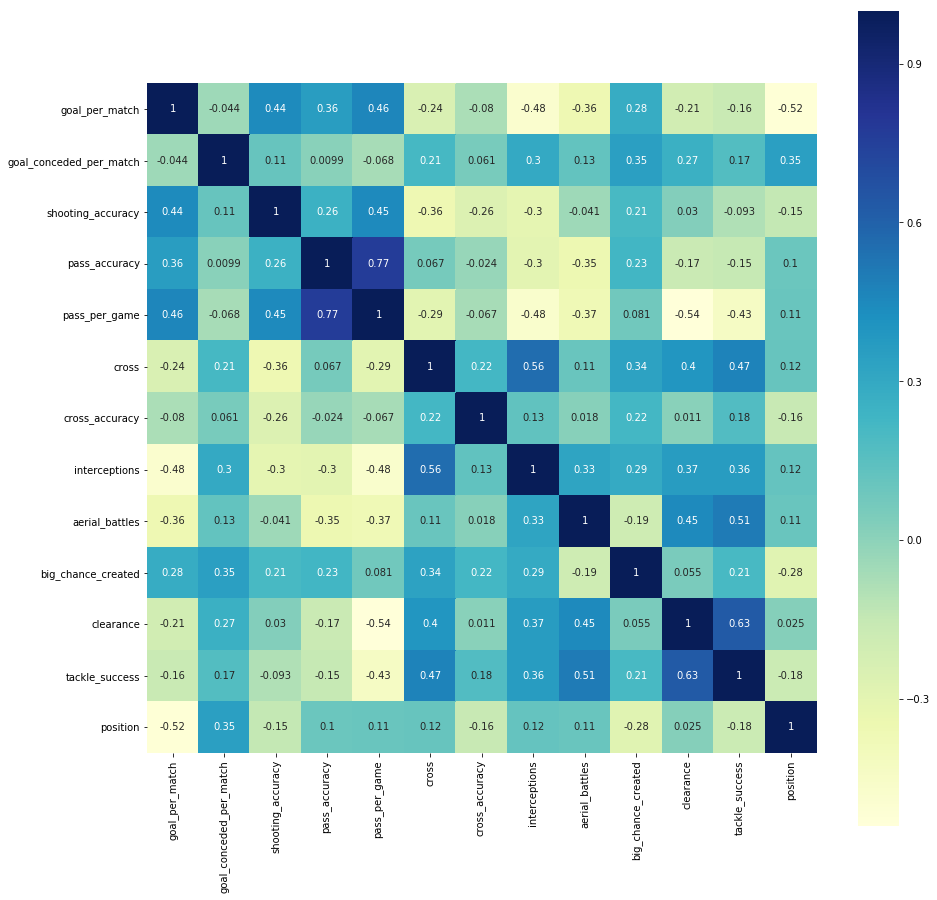

In [216]:
# To visualize the data combine x and Y to final_data
final_data = x.copy()
final_data['position'] = Y

f, ax = plt.subplots(figsize=(15, 15))
corr = final_data.corr()
sns.heatmap(corr, mask=np.zeros_like(corr, dtype=np.bool), annot=True, cmap='YlGnBu', square=True, ax=ax)

### Insight from heatmap above:  
#### Generally, it looks like 'won', 'lost', 'drawn', 'goal_per_match', 'goal_per_conceded_per_match', and'big_chance_created' has a correlation to position.


In [217]:
# To visualize how each position differ from each other, subset the dataset by positions
position1 = final_data[final_data['position'] == 0]
position2 = final_data[final_data['position'] == 1]
position3 = final_data[final_data['position'] == 2]
position4 = final_data[final_data['position'] == 3]

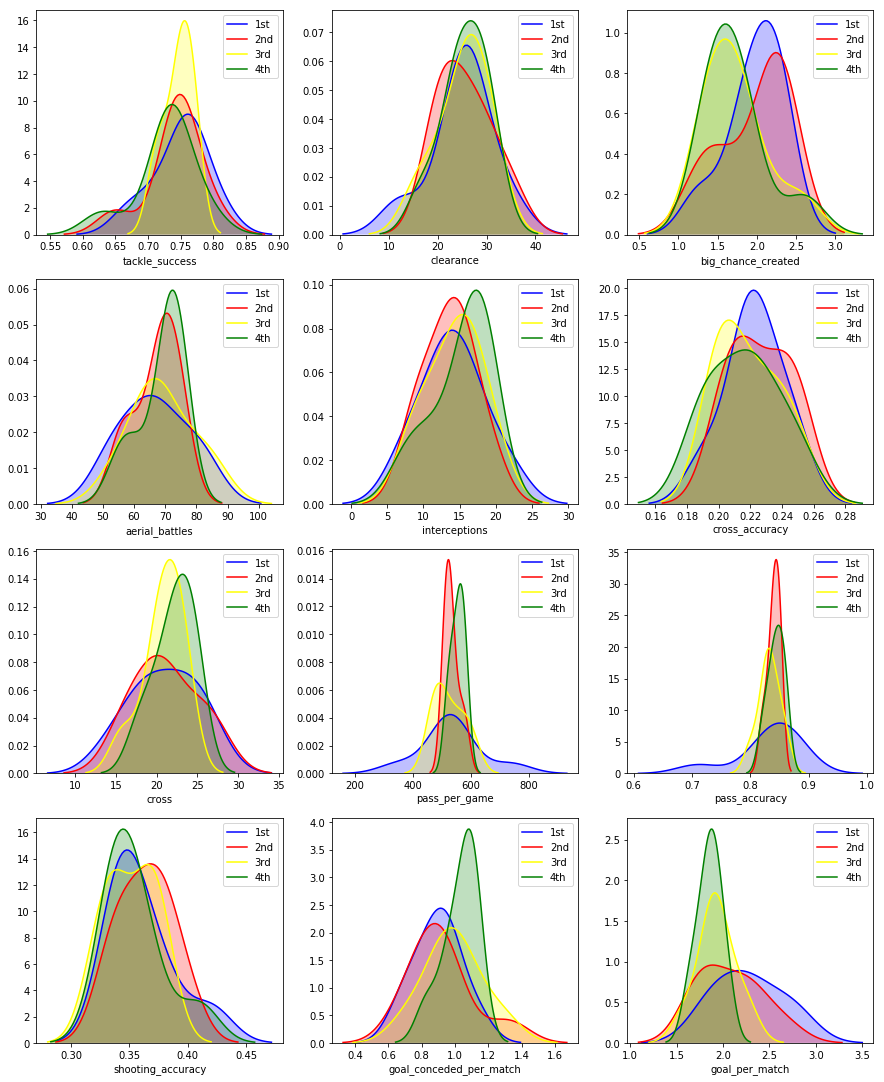

In [218]:
f, axes = plt.subplots(4, 3, figsize=(15, 19))

sns.distplot(position1['tackle_success'], hist=False, color='blue', kde_kws={'shade': True}, ax=axes[0, 0], label='1st')
sns.distplot(position2['tackle_success'], hist=False, color='red', kde_kws={'shade': True}, ax=axes[0, 0], label='2nd')
sns.distplot(position3['tackle_success'], hist=False, color='yellow', kde_kws={'shade': True}, ax=axes[0, 0],label='3rd')
sns.distplot(position4['tackle_success'], hist=False, color='green', kde_kws={'shade': True}, ax=axes[0, 0],label='4th')

sns.distplot(position1['clearance'], hist=False, color='blue', kde_kws={'shade': True}, ax=axes[0, 1],label='1st')
sns.distplot(position2['clearance'], hist=False, color='red', kde_kws={'shade': True}, ax=axes[0, 1], label='2nd')
sns.distplot(position3['clearance'], hist=False, color='yellow', kde_kws={'shade': True}, ax=axes[0, 1], label='3rd')
sns.distplot(position4['clearance'], hist=False, color='green', kde_kws={'shade': True}, ax=axes[0, 1], label='4th')

sns.distplot(position1['big_chance_created'], hist=False, color='blue', kde_kws={'shade': True}, ax=axes[0, 2],label='1st')
sns.distplot(position2['big_chance_created'], hist=False, color='red', kde_kws={'shade': True}, ax=axes[0, 2], label='2nd')
sns.distplot(position3['big_chance_created'], hist=False, color='yellow', kde_kws={'shade': True}, ax=axes[0, 2], label='3rd')
sns.distplot(position4['big_chance_created'], hist=False, color='green', kde_kws={'shade': True}, ax=axes[0, 2], label='4th')

sns.distplot(position1['aerial_battles'], hist=False, color='blue', kde_kws={'shade': True}, ax=axes[1, 0],label='1st')
sns.distplot(position2['aerial_battles'], hist=False, color='red', kde_kws={'shade': True}, ax=axes[1, 0], label='2nd')
sns.distplot(position3['aerial_battles'], hist=False, color='yellow', kde_kws={'shade': True}, ax=axes[1, 0], label='3rd')
sns.distplot(position4['aerial_battles'], hist=False, color='green', kde_kws={'shade': True}, ax=axes[1, 0], label='4th')

sns.distplot(position1['interceptions'], hist=False, color='blue', kde_kws={'shade': True}, ax=axes[1, 1],label='1st')
sns.distplot(position2['interceptions'], hist=False, color='red', kde_kws={'shade': True}, ax=axes[1, 1], label='2nd')
sns.distplot(position3['interceptions'], hist=False, color='yellow', kde_kws={'shade': True}, ax=axes[1, 1], label='3rd')
sns.distplot(position4['interceptions'], hist=False, color='green', kde_kws={'shade': True}, ax=axes[1, 1], label='4th')

sns.distplot(position1['cross_accuracy'], hist=False, color='blue', kde_kws={'shade': True}, ax=axes[1, 2],label='1st')
sns.distplot(position2['cross_accuracy'], hist=False, color='red', kde_kws={'shade': True}, ax=axes[1, 2], label='2nd')
sns.distplot(position3['cross_accuracy'], hist=False, color='yellow', kde_kws={'shade': True}, ax=axes[1, 2], label='3rd')
sns.distplot(position4['cross_accuracy'], hist=False, color='green', kde_kws={'shade': True}, ax=axes[1, 2], label='4th')

sns.distplot(position1['cross'], hist=False, color='blue', kde_kws={'shade': True}, ax=axes[2, 0],label='1st')
sns.distplot(position2['cross'], hist=False, color='red', kde_kws={'shade': True}, ax=axes[2, 0], label='2nd')
sns.distplot(position3['cross'], hist=False, color='yellow', kde_kws={'shade': True}, ax=axes[2, 0], label='3rd')
sns.distplot(position4['cross'], hist=False, color='green', kde_kws={'shade': True}, ax=axes[2, 0], label='4th')

sns.distplot(position1['pass_per_game'], hist=False, color='blue', kde_kws={'shade': True}, ax=axes[2, 1],label='1st')
sns.distplot(position2['pass_per_game'], hist=False, color='red', kde_kws={'shade': True}, ax=axes[2, 1], label='2nd')
sns.distplot(position3['pass_per_game'], hist=False, color='yellow', kde_kws={'shade': True}, ax=axes[2, 1], label='3rd')
sns.distplot(position4['pass_per_game'], hist=False, color='green', kde_kws={'shade': True}, ax=axes[2, 1], label='4th')

sns.distplot(position1['pass_accuracy'], hist=False, color='blue', kde_kws={'shade': True}, ax=axes[2, 2],label='1st')
sns.distplot(position2['pass_accuracy'], hist=False, color='red', kde_kws={'shade': True}, ax=axes[2, 2], label='2nd')
sns.distplot(position3['pass_accuracy'], hist=False, color='yellow', kde_kws={'shade': True}, ax=axes[2, 2], label='3rd')
sns.distplot(position4['pass_accuracy'], hist=False, color='green', kde_kws={'shade': True}, ax=axes[2, 2], label='4th')

sns.distplot(position1['shooting_accuracy'], hist=False, color='blue', kde_kws={'shade': True}, ax=axes[3, 0],label='1st')
sns.distplot(position2['shooting_accuracy'], hist=False, color='red', kde_kws={'shade': True}, ax=axes[3, 0], label='2nd')
sns.distplot(position3['shooting_accuracy'], hist=False, color='yellow', kde_kws={'shade': True}, ax=axes[3, 0], label='3rd')
sns.distplot(position4['shooting_accuracy'], hist=False, color='green', kde_kws={'shade': True}, ax=axes[3, 0], label='4th')

sns.distplot(position1['goal_conceded_per_match'], hist=False, color='blue', kde_kws={'shade': True}, ax=axes[3, 1],label='1st')
sns.distplot(position2['goal_conceded_per_match'], hist=False, color='red', kde_kws={'shade': True}, ax=axes[3, 1], label='2nd')
sns.distplot(position3['goal_conceded_per_match'], hist=False, color='yellow', kde_kws={'shade': True}, ax=axes[3, 1], label='3rd')
sns.distplot(position4['goal_conceded_per_match'], hist=False, color='green', kde_kws={'shade': True}, ax=axes[3, 1], label='4th')

sns.distplot(position1['goal_per_match'], hist=False, color='blue', kde_kws={'shade': True}, ax=axes[3, 2],label='1st')
sns.distplot(position2['goal_per_match'], hist=False, color='red', kde_kws={'shade': True}, ax=axes[3, 2], label='2nd')
sns.distplot(position3['goal_per_match'], hist=False, color='yellow', kde_kws={'shade': True}, ax=axes[3, 2], label='3rd')
sns.distplot(position4['goal_per_match'], hist=False, color='green', kde_kws={'shade': True}, ax=axes[3, 2], label='4th')

### Insight from displots above:  
#### Big chance created: There is clear signal that more big chance created is better for team's rank.  
#### Pass per game and Pass accuracy: 1st teams usually have dispersive range of the features than other ranks  
#### Goal conceded per match: 4th teams has much more goal conceded than other ranks  
#### Goal per match: 1st and 2nd has dispersive range of goal per match, but 3rd and 4th has a lot of goals between 1.5 to 2.5.
#### Tackle Success, Clearance, Aerial battles, Interceptions, Cross accuracy, Cross, Shooting accuracy: I do not see much information on this plot.  
### Let's see if my visual analysis is relevantly correct by using backward elimination and feature selection model from scikit-learn(KBest)

In [219]:
# Load ML models
logist_model = LogisticRegression(random_state = 50)
svm_model = svm.SVC(gamma='scale', decision_function_shape='ovo')
xb_model = XGBClassifier()
knn_model = KNeighborsClassifier()
rf_model = RandomForestClassifier()

In [220]:
selector_logist = RFE(logist_model, 5, step=1)
selector_svm = RFE(svm_model, 5, step=1)
selector_xb = RFE(xb_model, 5, step=1)
selector_knn = RFE(knn_model, 5, step=1)
selector_rf = RFE(rf_model, 5, step=1)

In [221]:
selector_logist = selector_logist.fit(x, Y)
print(selector_logist.support_, '\n', selector_logist.ranking_, '\n', x.columns)

[ True  True False  True False False False False False  True False  True] 
 [1 1 4 1 8 2 5 3 7 1 6 1] 
 Index(['goal_per_match', 'goal_conceded_per_match', 'shooting_accuracy',
       'pass_accuracy', 'pass_per_game', 'cross', 'cross_accuracy',
       'interceptions', 'aerial_battles', 'big_chance_created', 'clearance',
       'tackle_success'],
      dtype='object')


#### Logistics Regression: goal_conceded_per_match, interceptions, big_chance_created, drawn, lost

In [222]:
logist_x = x[['goal_per_match', 'goal_conceded_per_match', 'pass_accuracy', 'big_chance_created', 'tackle_success']]
logist_x.head()

,goal_per_match,goal_conceded_per_match,pass_accuracy,big_chance_created,tackle_success
0,1.71,0.95,0.84,2.315789,0.73
1,1.87,0.95,0.84,1.736842,0.75
2,1.79,1.08,0.86,1.631579,0.74
3,1.89,0.97,0.86,1.842105,0.79
4,1.95,1.29,0.85,2.552632,0.74


In [223]:
selector_xb = selector_xb.fit(x, Y)
print(selector_xb.support_, '\n', selector_xb.ranking_, '\n', x.columns)

[ True  True False  True  True False False False False  True False False] 
 [1 1 6 1 1 7 4 8 5 1 3 2] 
 Index(['goal_per_match', 'goal_conceded_per_match', 'shooting_accuracy',
       'pass_accuracy', 'pass_per_game', 'cross', 'cross_accuracy',
       'interceptions', 'aerial_battles', 'big_chance_created', 'clearance',
       'tackle_success'],
      dtype='object')


#### Xgboost: pass_accuracy, pass_per_game, drawn, lost, won

In [224]:
xb_x = x[['goal_per_match', 'goal_conceded_per_match', 'pass_accuracy', 'pass_per_game', 'big_chance_created']]
xb_x.head()

,goal_per_match,goal_conceded_per_match,pass_accuracy,pass_per_game,big_chance_created
0,1.71,0.95,0.84,559.18,2.315789
1,1.87,0.95,0.84,540.18,1.736842
2,1.79,1.08,0.86,567.39,1.631579
3,1.89,0.97,0.86,555.53,1.842105
4,1.95,1.29,0.85,542.08,2.552632


In [225]:
selector_rf = selector_rf.fit(x, Y)
print(selector_rf.support_, '\n', selector_rf.ranking_, '\n', x.columns)

[ True  True False False  True False False False  True  True False False] 
 [1 1 8 6 1 4 2 7 1 1 5 3] 
 Index(['goal_per_match', 'goal_conceded_per_match', 'shooting_accuracy',
       'pass_accuracy', 'pass_per_game', 'cross', 'cross_accuracy',
       'interceptions', 'aerial_battles', 'big_chance_created', 'clearance',
       'tackle_success'],
      dtype='object')


#### Random Forest: goal_per_match, goal_conceded_per_match, pass_per_game, big_chance_created, lost

In [226]:
rf_x = x[['goal_per_match', 'goal_conceded_per_match', 'pass_per_game', 'cross', 'big_chance_created']]
rf_x.head()

,goal_per_match,goal_conceded_per_match,pass_per_game,cross,big_chance_created
0,1.71,0.95,559.18,19.842105,2.315789
1,1.87,0.95,540.18,22.789474,1.736842
2,1.79,1.08,567.39,19.815789,1.631579
3,1.89,0.97,555.53,25.026316,1.842105
4,1.95,1.29,542.08,23.578947,2.552632


#### SVM and KNN does not provie logic to rank the feature; therefore, we cannot implement this method.  
#### For SVM and KNN, feature will be selected according to EDA

In [227]:
x_knn_svm = x[['goal_per_match', 'goal_conceded_per_match', 'pass_accuracy', 'pass_per_game', 'big_chance_created']]
x_knn_svm.head()

,goal_per_match,goal_conceded_per_match,pass_accuracy,pass_per_game,big_chance_created
0,1.71,0.95,0.84,559.18,2.315789
1,1.87,0.95,0.84,540.18,1.736842
2,1.79,1.08,0.86,567.39,1.631579
3,1.89,0.97,0.86,555.53,1.842105
4,1.95,1.29,0.85,542.08,2.552632


In [249]:
final_data_y = final_data.loc[:, final_data.columns == 'position']
final_data_x = final_data.loc[:, final_data.columns != 'position']
norm_final_data = pd.DataFrame(preprocessing.normalize(final_data_x))
norm_final_data.columns = final_data_x.columns

In [250]:
norm_final_data = pd.concat([norm_final_data, final_data_y], axis=1, sort=False)

In [251]:
norm_final_data

,goal_per_match,goal_conceded_per_match,shooting_accuracy,pass_accuracy,pass_per_game,cross,cross_accuracy,interceptions,aerial_battles,big_chance_created,clearance,tackle_success,position
0,0.003026,0.001681,0.000655,0.001486,0.989536,0.035113,0.000442,0.034182,0.129695,0.004098,0.039537,0.001292,1
1,0.003410,0.001732,0.000675,0.001532,0.985073,0.041559,0.000365,0.036568,0.155582,0.003167,0.048277,0.001368,2
2,0.003121,0.001883,0.000715,0.001500,0.989372,0.034553,0.000384,0.024825,0.127430,0.002845,0.055386,0.001290,3
3,0.003364,0.001727,0.000605,0.001531,0.988802,0.044545,0.000338,0.029790,0.133026,0.003279,0.040891,0.001406,3
4,0.003567,0.002360,0.000677,0.001555,0.991586,0.043131,0.000402,0.029123,0.112449,0.004669,0.036873,0.001354,2
5,0.003523,0.002107,0.000671,0.001566,0.988513,0.045526,0.000354,0.034782,0.129317,0.004857,0.052835,0.001380,3
6,0.004185,0.001625,0.000654,0.001569,0.989498,0.033827,0.000355,0.025075,0.131866,0.002360,0.041251,0.001327,0
7,0.003552,0.001554,0.000684,0.001535,0.986723,0.033202,0.000407,0.018305,0.149702,0.003213,0.049998,0.001498,0
8,0.003825,0.001452,0.000675,0.001698,0.983279,0.043550,0.000511,0.020456,0.164455,0.002692,0.061422,0.001575,2
9,0.004016,0.002099,0.000693,0.001692,0.988323,0.046291,0.000408,0.027035,0.132438,0.003004,0.052621,0.001549,2


## Test ML models
a. Multinomial Logistic Regression  
b. Support Vector Machine  
c. XG boost  
d. Knn  
e. Random Forest

In [252]:
data_shuffled = shuffle(norm_final_data).reset_index(drop=True)

train = data_shuffled.iloc[:21]
test = data_shuffled.iloc[21:]

In [253]:
x_train = train.loc[:, train.columns != 'position']
y_train = train.loc[:, train.columns == 'position']

x_test = test.loc[:, test.columns != 'position']
y_test = test.loc[:, test.columns == 'position']

In [254]:
logist_model = logist_model.fit(x_train[logist_x.columns], y_train)
svm_model = svm_model.fit(x_train[x_knn_svm.columns], y_train)
xb_model = xb_model.fit(x_train[xb_x.columns], y_train)
knn_model = knn_model.fit(x_train[x_knn_svm.columns], y_train)
rf_model = rf_model.fit(x_train[rf_x.columns], y_train)

In [255]:
# Accuracy Score on training set
print('Logistic Regression: ', accuracy_score(y_train, logist_model.predict(x_train[logist_x.columns])),'\n'
      , 'SVM: ', accuracy_score(y_train, svm_model.predict(x_train[x_knn_svm.columns])), '\n'
      , 'Xgboost: ', accuracy_score(y_train, xb_model.predict(x_train[xb_x.columns])), '\n'
      , 'KNN: ', accuracy_score(y_train, knn_model.predict(x_train[x_knn_svm.columns])), '\n'
      , 'Random Forest: ', accuracy_score(y_train, rf_model.predict(x_train[rf_x.columns]))
     ) 

Logistic Regression:  0.42857142857142855 
 SVM:  0.42857142857142855 
 Xgboost:  1.0 
 KNN:  0.47619047619047616 
 Random Forest:  1.0


In [256]:
# Accuracy Score on test set
print('Logistic Regression: ', accuracy_score(y_test, logist_model.predict(x_test[logist_x.columns])),'\n'
      , 'SVM: ', accuracy_score(y_test, svm_model.predict(x_test[x_knn_svm.columns])), '\n'
      , 'Xgboost: ', accuracy_score(y_test, xb_model.predict(x_test[xb_x.columns])), '\n'
      , 'KNN: ', accuracy_score(y_test, knn_model.predict(x_test[x_knn_svm.columns])), '\n'
      , 'Random Forest: ', accuracy_score(y_test, rf_model.predict(x_test[rf_x.columns]))
     ) 

Logistic Regression:  0.18181818181818182 
 SVM:  0.2727272727272727 
 Xgboost:  0.36363636363636365 
 KNN:  0.45454545454545453 
 Random Forest:  0.18181818181818182


### We can clearly see the models are overfitting due to the low volume of dataset. Also general accuracy of models are pretty low.

# 4. Choose the best model to predict the final table

### Based on the prediction above, it is expected that all of the models will not perform well due to overfitting. But let's see how it does with unseen data.

### Getting the 2017/18 data for final prediction
>#### 1. current standing table
>#### 2. current club's match data

In [257]:
table2017 = pd.read_csv('/Users/hyunilyoo/Documents/analytics/epl_prediction/table2017_crawler/table2017.csv')
table2017

,club_name,drawn,goal,goal_against,lost,points,position,won
0,Manchester City,3,83,20,1,78,1,25
1,Manchester United,5,56,22,5,62,2,19
2,Liverpool,9,67,32,3,60,3,17
3,Tottenham Hotspur,7,55,24,5,58,4,17
4,Chelsea,5,50,26,8,53,5,16
5,Arsenal,6,52,41,10,45,6,13
6,Burnley,10,24,26,9,40,7,10
7,Leicester City,10,41,42,10,37,8,9
8,Watford,6,39,47,13,36,9,10
9,Brighton and Hove Albion,10,28,38,11,34,10,8


#### Bournemouth has to be changed to AFC Bournemouth because club's match data has it as AFC Bournemouth. Therefore, it has to be changed to join the data frame.

In [258]:
table2017 = table2017[['club_name', 'won', 'drawn', 'lost', 'goal', 'goal_against', 'points', 'position']]
table2017.iat[11,0] = 'AFC Bournemouth'
table2017

,club_name,won,drawn,lost,goal,goal_against,points,position
0,Manchester City,25,3,1,83,20,78,1
1,Manchester United,19,5,5,56,22,62,2
2,Liverpool,17,9,3,67,32,60,3
3,Tottenham Hotspur,17,7,5,55,24,58,4
4,Chelsea,16,5,8,50,26,53,5
5,Arsenal,13,6,10,52,41,45,6
6,Burnley,10,10,9,24,26,40,7
7,Leicester City,9,10,10,41,42,37,8
8,Watford,10,6,13,39,47,36,9
9,Brighton and Hove Albion,8,10,11,28,38,34,10


In [259]:
table2017['position'] = table2017['position'].astype(object)

In [260]:
stats2017 = pd.read_csv('/Users/hyunilyoo/Documents/analytics/epl_prediction/clubstats2017_crawler/club_stats_2017.csv')

In [261]:
stats2017.head()

,aerial_battles,big_chance_created,clearance,club_name,cross,cross_accuracy,goal_conceded_per_match,goal_per_match,interceptions,pass_accuracy,pass_per_game,shooting_accuracy,shot_on_target,tackle_success
0,"2,061",60,616,Arsenal,438,21%,1.41,1.79,336,84%,629.52,38%,176,69%
1,"2,588",38,865,Stoke City,481,24%,1.86,0.97,361,73%,351.90,33%,104,66%
2,"2,357",28,811,West Ham United,574,21%,1.86,1.24,368,75%,373.79,38%,102,67%
3,"2,025",61,624,Tottenham Hotspur,651,20%,0.83,1.90,277,84%,576.62,33%,168,63%
4,"2,405",33,735,Watford,550,23%,1.62,1.34,359,76%,418.00,27%,95,64%


In [262]:
# Get rid of unnecessary signs
def clean_sign_2017(club):
    """Excluding non-numeric values such as comma and %"""
    club['cross_accuracy'] = club['cross_accuracy'].map(lambda x: x.rstrip('%'))
    club['pass_accuracy'] = club['pass_accuracy'].map(lambda x: x.rstrip('%'))
    club['shooting_accuracy'] = club['shooting_accuracy'].map(lambda x: x.rstrip('%')) 
    club['tackle_success'] = club['tackle_success'].map(lambda x: x.rstrip('%'))
    club['aerial_battles'] = club['aerial_battles'].str.replace(',','')
    
clean_sign_2017(stats2017)
stats2017

,aerial_battles,big_chance_created,clearance,club_name,cross,cross_accuracy,goal_conceded_per_match,goal_per_match,interceptions,pass_accuracy,pass_per_game,shooting_accuracy,shot_on_target,tackle_success
0,2061,60,616,Arsenal,438,21,1.41,1.79,336,84,629.52,38,176,69
1,2588,38,865,Stoke City,481,24,1.86,0.97,361,73,351.90,33,104,66
2,2357,28,811,West Ham United,574,21,1.86,1.24,368,75,373.79,38,102,67
3,2025,61,624,Tottenham Hotspur,651,20,0.83,1.90,277,84,576.62,33,168,63
4,2405,33,735,Watford,550,23,1.62,1.34,359,76,418.00,27,95,64
5,2114,34,681,Southampton,641,21,1.41,1.00,355,79,475.55,29,104,70
6,2219,27,756,West Bromwich Albion,608,24,1.48,0.76,363,72,345.72,30,86,65
7,2390,36,914,Newcastle United,456,21,1.38,0.93,328,72,356.93,34,119,67
8,2069,20,724,Swansea City,528,20,1.45,0.86,298,78,417.03,29,72,68
9,2142,27,976,Everton,459,24,1.69,1.14,416,74,386.41,33,87,71


### Averaging the data that are not in average.

In [263]:
data_transform(stats2017)

def for_stats17(club):
    club['aerial_battles'] = club['aerial_battles'] / 29
    club['interceptions'] = club['interceptions'] / 29
    club['cross'] = club['cross'] / 29
    club['clearance'] = club['clearance'] / 29
    club['big_chance_created'] = club['big_chance_created'] / 29
    club['shot_on_target'] = club['shot_on_target'] / 29
    club['cross_accuracy'] = club['cross_accuracy'] / 100
    club['pass_accuracy'] = club['pass_accuracy'] / 100
    club['shooting_accuracy'] = club['shooting_accuracy'] / 100
    club['tackle_success'] = club['tackle_success'] / 100

In [264]:
for_stats17(stats2017)

In [265]:
col_order(stats2017)

,club_name,goal_per_match,goal_conceded_per_match,shooting_accuracy,shot_on_target,pass_accuracy,pass_per_game,cross,cross_accuracy,interceptions,aerial_battles,big_chance_created,clearance,tackle_success
0,Arsenal,1.79,1.41,0.38,6.068966,0.84,629.52,15.103448,0.21,11.586207,71.068966,2.068966,21.241379,0.69
1,Stoke City,0.97,1.86,0.33,3.586207,0.73,351.90,16.586207,0.24,12.448276,89.241379,1.310345,29.827586,0.66
2,West Ham United,1.24,1.86,0.38,3.517241,0.75,373.79,19.793103,0.21,12.689655,81.275862,0.965517,27.965517,0.67
3,Tottenham Hotspur,1.90,0.83,0.33,5.793103,0.84,576.62,22.448276,0.20,9.551724,69.827586,2.103448,21.517241,0.63
4,Watford,1.34,1.62,0.27,3.275862,0.76,418.00,18.965517,0.23,12.379310,82.931034,1.137931,25.344828,0.64
5,Southampton,1.00,1.41,0.29,3.586207,0.79,475.55,22.103448,0.21,12.241379,72.896552,1.172414,23.482759,0.70
6,West Bromwich Albion,0.76,1.48,0.30,2.965517,0.72,345.72,20.965517,0.24,12.517241,76.517241,0.931034,26.068966,0.65
7,Newcastle United,0.93,1.38,0.34,4.103448,0.72,356.93,15.724138,0.21,11.310345,82.413793,1.241379,31.517241,0.67
8,Swansea City,0.86,1.45,0.29,2.482759,0.78,417.03,18.206897,0.20,10.275862,71.344828,0.689655,24.965517,0.68
9,Everton,1.14,1.69,0.33,3.000000,0.74,386.41,15.827586,0.24,14.344828,73.862069,0.931034,33.655172,0.71


In [266]:
dataset = stats2017.join(table2017.set_index('club_name'), on = 'club_name')
dataset = dataset[['club_name', 'position','goal_per_match', 'goal_conceded_per_match', 'shooting_accuracy', 'shot_on_target', 'pass_accuracy', 
        'pass_per_game', 'cross', 'cross_accuracy', 'interceptions', 'aerial_battles', 'big_chance_created', 'clearance', 
        'tackle_success', 'drawn', 'goal', 'goal_against']]

In [267]:
dataset

,club_name,position,goal_per_match,goal_conceded_per_match,shooting_accuracy,shot_on_target,pass_accuracy,pass_per_game,cross,cross_accuracy,interceptions,aerial_battles,big_chance_created,clearance,tackle_success,drawn,goal,goal_against
0,Arsenal,6,1.79,1.41,0.38,6.068966,0.84,629.52,15.103448,0.21,11.586207,71.068966,2.068966,21.241379,0.69,6,52,41
1,Stoke City,19,0.97,1.86,0.33,3.586207,0.73,351.90,16.586207,0.24,12.448276,89.241379,1.310345,29.827586,0.66,9,28,54
2,West Ham United,14,1.24,1.86,0.38,3.517241,0.75,373.79,19.793103,0.21,12.689655,81.275862,0.965517,27.965517,0.67,9,36,54
3,Tottenham Hotspur,4,1.90,0.83,0.33,5.793103,0.84,576.62,22.448276,0.20,9.551724,69.827586,2.103448,21.517241,0.63,7,55,24
4,Watford,9,1.34,1.62,0.27,3.275862,0.76,418.00,18.965517,0.23,12.379310,82.931034,1.137931,25.344828,0.64,6,39,47
5,Southampton,17,1.00,1.41,0.29,3.586207,0.79,475.55,22.103448,0.21,12.241379,72.896552,1.172414,23.482759,0.70,13,29,41
6,West Bromwich Albion,20,0.76,1.48,0.30,2.965517,0.72,345.72,20.965517,0.24,12.517241,76.517241,0.931034,26.068966,0.65,11,22,43
7,Newcastle United,16,0.93,1.38,0.34,4.103448,0.72,356.93,15.724138,0.21,11.310345,82.413793,1.241379,31.517241,0.67,8,27,40
8,Swansea City,13,0.86,1.45,0.29,2.482759,0.78,417.03,18.206897,0.20,10.275862,71.344828,0.689655,24.965517,0.68,6,25,42
9,Everton,11,1.14,1.69,0.33,3.000000,0.74,386.41,15.827586,0.24,14.344828,73.862069,0.931034,33.655172,0.71,7,33,49


In [268]:
dataset_x = dataset.iloc[:, 2:]

In [269]:
norm_dataset = pd.DataFrame(preprocessing.normalize(dataset_x))
norm_dataset.columns = dataset_x.columns
norm_dataset

,goal_per_match,goal_conceded_per_match,shooting_accuracy,shot_on_target,pass_accuracy,pass_per_game,cross,cross_accuracy,interceptions,aerial_battles,big_chance_created,clearance,tackle_success,drawn,goal,goal_against
0,0.002807,0.002211,0.000596,0.009517,0.001317,0.987213,0.023685,0.000329,0.018169,0.111450,0.003245,0.033311,0.001082,0.009409,0.081546,0.064296
1,0.002621,0.005027,0.000892,0.009692,0.001973,0.951017,0.044825,0.000649,0.033642,0.241177,0.003541,0.080610,0.001784,0.024323,0.075671,0.145936
2,0.003181,0.004771,0.000975,0.009022,0.001924,0.958839,0.050773,0.000539,0.032551,0.208487,0.002477,0.071737,0.001719,0.023087,0.092347,0.138520
3,0.003248,0.001419,0.000564,0.009904,0.001436,0.985829,0.038379,0.000342,0.016330,0.119382,0.003596,0.036787,0.001077,0.011968,0.094032,0.041032
4,0.003103,0.003751,0.000625,0.007585,0.001760,0.967809,0.043911,0.000533,0.028662,0.192013,0.002635,0.058682,0.001482,0.013892,0.090298,0.108821
5,0.002061,0.002906,0.000598,0.007392,0.001628,0.980232,0.045561,0.000433,0.025233,0.150259,0.002417,0.048404,0.001443,0.026796,0.059777,0.084512
6,0.002115,0.004119,0.000835,0.008253,0.002004,0.962115,0.058346,0.000668,0.034835,0.212942,0.002591,0.072548,0.001809,0.030612,0.061224,0.119666
7,0.002504,0.003715,0.000915,0.011047,0.001938,0.960911,0.042332,0.000565,0.030449,0.221871,0.003342,0.084849,0.001804,0.021537,0.072688,0.107686
8,0.002013,0.003394,0.000679,0.005812,0.001826,0.976193,0.042619,0.000468,0.024054,0.167006,0.001614,0.058440,0.001592,0.014045,0.058521,0.098315
9,0.002851,0.004226,0.000825,0.007502,0.001851,0.966292,0.039580,0.000600,0.035872,0.184706,0.002328,0.084161,0.001775,0.017505,0.082523,0.122534


In [270]:
p_logist_position = logist_model.predict(norm_dataset[logist_x.columns])
p_svm_position = svm_model.predict(norm_dataset[x_knn_svm.columns])
p_xb_position = xb_model.predict(norm_dataset[xb_x.columns])
p_knn_position = knn_model.predict(norm_dataset[x_knn_svm.columns])
p_rf_position = rf_model.predict(norm_dataset[rf_x.columns])

In [271]:
final_table= table2017.drop(['won', 'drawn', 'lost', 'goal', 'goal_against', 'points'],axis=1)

In [272]:
final_table['position'] = [1, 2, 4, 3, 5, 6, 7, 9, 14, 15, 8, 12, 18, 13, 16, 10, 17, 11, 19, 20] # Real positions in 2017/18 season
final_table['position'] = final_table['position'] - 1
final_table['logist'] = p_logist_position
final_table['svm'] = p_svm_position
final_table['xgboost'] = p_xb_position
final_table['knn'] = p_knn_position
final_table['random_forest'] = p_rf_position
final_table

,club_name,position,logist,svm,xgboost,knn,random_forest
0,Manchester City,0,2,2,2,2,2
1,Manchester United,1,2,2,3,2,3
2,Liverpool,3,2,2,3,2,3
3,Tottenham Hotspur,2,1,2,1,2,1
4,Chelsea,4,2,2,3,2,3
5,Arsenal,5,2,2,3,2,3
6,Burnley,6,2,2,3,2,3
7,Leicester City,8,2,2,2,2,2
8,Watford,13,2,2,3,2,3
9,Brighton and Hove Albion,14,2,2,3,2,3


### This is the final table that is predicted from the model. However, there are many teams that get high predicted position because the model that I made is based on the only top4 of the table; thus, I might exclude the variables that differenciate other positions that is below 4.

### Let see the prediction on the teams that was chosen from the beginning of the project.

In [273]:
final_table = final_table[(final_table['club_name'] == 'Manchester City') | (final_table['club_name'] == 'Manchester United')|
                          (final_table['club_name'] == 'Liverpool') | (final_table['club_name'] == 'Tottenham Hotspur')|
                          (final_table['club_name'] == 'Chelsea') | (final_table['club_name'] == 'Leicester City')]

In [274]:
final_table

,club_name,position,logist,svm,xgboost,knn,random_forest
0,Manchester City,0,2,2,2,2,2
1,Manchester United,1,2,2,3,2,3
2,Liverpool,3,2,2,3,2,3
3,Tottenham Hotspur,2,1,2,1,2,1
4,Chelsea,4,2,2,3,2,3
7,Leicester City,8,2,2,2,2,2
